In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib_scalebar.scalebar import ScaleBar
import skimage.morphology as morph

from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_tomocube_stack, import_holomonitor_stack

In [3]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

In [4]:
# folder = '../../data/Tomocube/MDCK_10.02.2025/A2P1'
# filename = '250210.113448.MDCK dynamics.001.MDCK B.A2'

# n_im, h_im = import_tomocube_stack(folder, filename, h_scaling=vox_to_um[0], f_min=2, f_max=3)
# n_im[n_im == 0] = np.nan

# df = pd.read_csv(f"{folder}/area_volume_filtered.csv")
# edges = np.load(f"{folder}/cell_edges.npy")[9]

# Import Holomonitor
file = "A1-18"
dir  = "../../data/Holomonitor/MDCK_19.03.2024/"

fmin = 132
h_im = import_holomonitor_stack(dir, file, f_min=fmin, f_max=fmin+1)
edges = np.load(f"{dir}{file}/cell_edges.npy")[2]
areas = np.load(f"{dir}{file}/cell_areas.npy")[2]

df_holo = pd.read_csv(f"{dir}{file}/area_volume_unfiltered.csv")
df = df_holo[df_holo.frame == 2]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/Holomonitor/MDCK_19.03.2024/A1-18/cell_edges.npy'

In [164]:
edges = morph.dilation(edges, morph.disk(1))
e_cmap = mpl.colors.ListedColormap(['none', 'w'])

In [165]:
cellwise_heigts = np.copy(areas)
heights = []
counts = 0

for l in np.unique(areas):
    mask = (areas == l)
    df_mask = df.label==l

    counts += np.sum(df_mask)
    if np.sum(df_mask) == 0:
        continue
    cellwise_heigts[mask] = df[df_mask].h_avrg.values[0]
    heights.append(df[df_mask].h_avrg.values[0])

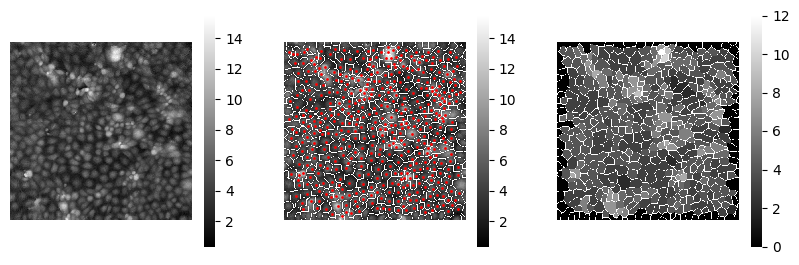

In [166]:
fig, ax = plt.subplots(1,3, figsize=(10, 3), gridspec_kw={"width_ratios":[1, 1, 1]})

sns.heatmap(h_im[0].T, ax=ax[0], square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(h_im[0].T, ax=ax[1], square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(cellwise_heigts.T, ax=ax[2], cmap="gray", square=True, xticklabels=False, yticklabels=False, cbar=True)

ax[1].plot(df[df.frame==2].x, df[df.frame==2].y, 'r.', ms=2, alpha=1)
sns.heatmap(edges.T==1, ax=ax[1], cmap=e_cmap, square=True, xticklabels=False, yticklabels=False, cbar=False)
sns.heatmap(edges.T==1, ax=ax[2], cmap=e_cmap, square=True, xticklabels=False, yticklabels=False, cbar=False)
#sns.heatmap(im_edges,         ax=ax[0,0], cmap=e_cmap, square=True, xticklabels=False, yticklabels=False, cbar=False)


ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

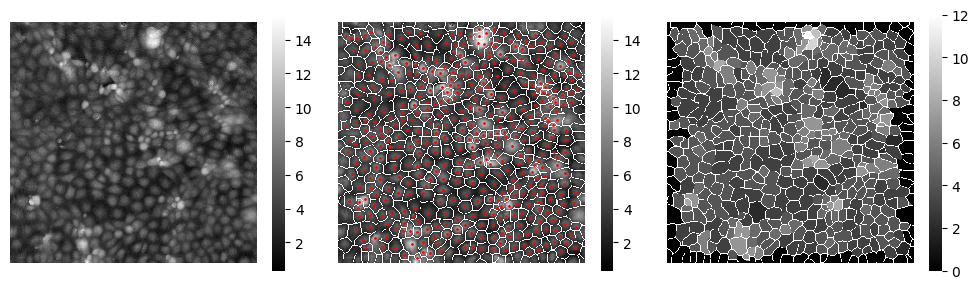

In [167]:
fig.tight_layout()
fig.savefig(f"../../figs/illustrations/cell_area_illustration.png", dpi=300)
fig